Lecture des routes + Uniformisation de tous les points

In [3]:
from osgeo import ogr
import os
import math
import time

import sys 
from osgeo import osr

import numpy as np
from operator import itemgetter

import copy


class LISection() :
    
    def __init__(self):
        self.Sections = []

    def addSection(self, Section):
        self.Sections.append(Section)
        
    def removeSectionById(self, ID):
        for elem in [x for x in self.Sections if x.IDSection == ID] :
            self.Sections.remove(elem)
                        
    def calculWeightGlobal(self):
        for Section in self.Sections :
            Section.calculWeight()
            
    def uniqueIDSection(self):
        for index, Section in enumerate(self.Sections) :
            Section.IDSection = index
            
    def returnValues(self, Fields, Param) :
        Array = list()
        if len(Fields) > 1 :
            for Section in self.Sections :
                dValue = Section.__dict__
                Value = [dValue[x] for x in Fields]
                if not Param :
                    Array.append(Value)
                elif Param == "Str" :
                    nValue = "-".join([str(x) for x in Value])
                    Array.append(nValue)
                elif  Param == "Unique" :
                    Array += Value
        return(Array)
    
    def CheckAndSetPointFinal(self, liste, ID) :
        BigDict = dict()
        for Section in self.Sections :
            outData = Section.setPointDeau(liste, ID)
            if outData :
                BigDict.update(outData)
        return BigDict

class InfoSection() :
    
    def __init__(self, inCompteurSegment, inCompteurFeature, inDist, inMaxSpeed, inHighWay, inSrc, inDest, inCentroide):
        self.IDSection= inCompteurSegment
        self.IDFeature = inCompteurFeature
        self.Dist = inDist
        self.MaxSpeed = inMaxSpeed
        self.HighWay = inHighWay
        self.Src = inSrc
        self.Dest = inDest
        self.idSrc = list()
        self.idDest = list()
        self.Centroide = inCentroide
        self.Path = list()
        self.PointDeau = ''
        self.Weight = 0
        self.Ajout = ''
        
    def setAjout(self, inAjout):
        self.Ajout = inAjout
        
    def setPath(self, Path, idSrc, idDest) :
        self.Path = Path
        self.idSrc = idSrc
        self.idDest = idDest
        
    def setPointDeau(self, outL, ID):
        if not self.PointDeau :
            returnDict = dict()
            inL = [self.idSrc, self.idDest]
            Corr = len(set(inL) & set(outL))
            if Corr == 2 :
                self.PointDeau = ID
                KeyList = ["%s-%s"%(str(x[0]), str(x[1])) for x in self.Path]
                for Key in KeyList :
                    returnDict[Key] = ID
            return returnDict
        
    def returnDict(self) :
        return list(self.__dict__.values())[1:]
    
    def calculWeight(self) :
        self.Weight = (self.Dist/(self.MaxSpeed/3.6))/60
        
def GetMinMax(Liste):
    minX = min([x[0] for x in Liste])
    maxX = max([x[0] for x in Liste])
    minY = min([x[1] for x in Liste])
    maxY = max([x[1] for x in Liste])
    maxXY = [maxX, maxY]
    minXY = [minX, minY]
    return(minXY, maxXY)

def CalculDistance(Point1, Point2, MoyNeed) :
    X1, Y1 = Point1
    X2, Y2 = Point2
    DiffX = (X1 - X2)**2
    DiffY = (Y1 - Y2)**2
    Diff = math.sqrt(DiffX + DiffY)
    if MoyNeed :
        MoyX = X1 - (X1 - X2)/2 
        MoyY = Y1 - (Y1 - Y2)/2
        Moy = [MoyX, MoyY]
        return(Diff, Moy)
    else :
        return Diff

shapefile = r"C:\Users\33647\Downloads\Jura\export_routes_jura_2_Project.shp"
driver = ogr.GetDriverByName("ESRI Shapefile")
dataSource = driver.Open(shapefile, 0)
layer = dataSource.GetLayer()

CompteurSegment = 0
CompteurFeature = 0
Point = []
ListeLigne = LISection()

t0 = time.time()

for feature in layer:
    CompteurFeature += 1
    MaxSpeed = feature.GetField("maxspeed")
    HighWay =  feature.GetField("highway")
    geom = feature.GetGeometryRef()
    WKT = geom.ExportToWkt()
    newWKT = WKT.replace("LINESTRING (", "").replace(")", "")
    if not WKT.startswith("LINESTRING"):
        print(WKT)
        pass
    newWKT = newWKT.split(",")
    for elem in list(range(0, len(newWKT)-1)) :
        #print(elem)
        Source = newWKT[elem]
        Dest = newWKT[elem + 1]
        Src = [round(float(x)) for x in Source.split(" ")]
        Dest = [round(float(x)) for x in Dest.split(" ")]
        if Src != Dest :
            Dist, Centroide = CalculDistance(Src, Dest, True)
            Point.append(Src)
            Point.append(Dest)
            IS = InfoSection(CompteurSegment, CompteurFeature, Dist, MaxSpeed, HighWay, Src, Dest, Centroide)
            ListeLigne.addSection(IS)
            CompteurSegment += 1

print(CompteurFeature)
del layer, feature, newWKT
print(time.time() - t0)
t1 = time.time()
print(len(Point))
PointUnique = [list(x) for x in set(tuple(x) for x in Point)]
print(len(PointUnique))
del Point, WKT

for iSection in ListeLigne.Sections :
    idSrc = PointUnique.index(iSection.Src)
    idDest = PointUnique.index(iSection.Dest)
    iSection.idSrc = idSrc
    iSection.idDest = idDest

print(time.time() - t1)

C:\Users\33647\Documents\WPy64-31241\python-3.12.4.amd64\Lib\site-packages\osgeo\ogr.py:563: FutureWarning: Neither ogr.UseExceptions() nor ogr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


2282
0.631648063659668
68270
32106
46.166948080062866


Reconstruction des Sections selon si elle croise des Noeuds important (Qui sont partagés avec d'autres Sections)

In [4]:
t1 = time.time()

ListePointLigneInOut =  ListeLigne.returnValues(["idSrc", "idDest"], "Unique")
ListePointLigneInOutUnique =  list(np.unique(ListePointLigneInOut))

ListePointLigneInOutSup3 = list()
for index, elem in enumerate(ListePointLigneInOutUnique) :
    Long = len([x for x in ListePointLigneInOut if x == elem])
    if Long > 2 :
        ListePointLigneInOutSup3.append(elem)

print(time.time() - t1)

del ListePointLigneInOut, ListePointLigneInOutUnique

print(len(ListeLigne.Sections))
LigneSupprimee = 0
LigneAjoutee = 0
ListeFeature = list(np.unique([x.IDFeature for x in ListeLigne.Sections]))
BigBreak = False
newListeSection = list()
t1 = time.time()

#aux = copy.deepcopy(ListeLigne)
for Feature in ListeFeature :
    SectionActuelle = [x for x in ListeLigne.Sections if x.IDFeature == Feature]
    SectionActuelle.sort(key=lambda x: x.IDSection, reverse=False)
    SActuelle = list()
    for index, S in enumerate(SectionActuelle) :
        if S.idSrc in ListePointLigneInOutSup3 and index != 0 and len(SActuelle) != 1:
            DistanceTotale = sum([x.Dist for x in SActuelle])
            FirstPoint = SActuelle[0].Src
            LastPoint = SActuelle[-1].Dest
            Path = [x.Src for x in SActuelle[:-1]] + [[x.Dest for x in SActuelle][-1]] 
            Min, Max = GetMinMax(Path)
            Distance, Centroide = CalculDistance(Min, Max, True)
            del Distance
            newIS = InfoSection(
                SActuelle[0].IDSection,
                Feature,
                DistanceTotale,
                SActuelle[0].MaxSpeed,
                SActuelle[0].HighWay,
                FirstPoint,
                LastPoint,
                Centroide,
            )
            newIS.setPath(Path, SActuelle[0].idSrc, SActuelle[-1].idDest)
            newIS.setAjout("Reconstruction")
            for elem in SActuelle :
                ListeLigne.removeSectionById(elem.IDSection)
            
            ListeLigne.addSection(newIS)
            LigneSupprimee += len(SActuelle)
            LigneAjoutee += 1
            SActuelle = [S]
        
        elif len(SActuelle) == 1 and S.idSrc in ListePointLigneInOutSup3 and index != 0 :
            LigneSupprimee += 1
            LigneAjoutee += 1
            ListeLigne.removeSectionById(SActuelle[-1].IDSection)
            newIS = SActuelle[-1]
            Path = [SActuelle[-1].Src, SActuelle[-1].Dest]
            newIS.setPath(Path, SActuelle[-1].idSrc, SActuelle[-1].idDest)
            newIS.setAjout("Reconstruction")
            ListeLigne.addSection(newIS)
            SActuelle = [S]
        else :
            SActuelle.append(S)
    
    if len(SActuelle) > 1 :
        DistanceTotale = sum([x.Dist for x in SActuelle])
        FirstPoint = SActuelle[0].Src
        LastPoint = SActuelle[-1].Dest
        Path = [x.Src for x in SActuelle[:-1]] + [[x.Dest for x in SActuelle][-1]] 
        Min, Max = GetMinMax(Path)
        Distance, Centroide = CalculDistance(Min, Max, True) 
        newIS = InfoSection(
            SActuelle[0].IDSection,
            Feature,
            DistanceTotale,
            SActuelle[0].MaxSpeed,
            SActuelle[0].HighWay,
            FirstPoint,
            LastPoint,
            Centroide,
        )
        newIS.setPath(Path, SActuelle[0].idSrc, SActuelle[-1].idDest)
        newIS.setAjout("Reconstruction")
        for elem in SActuelle :
            ListeLigne.removeSectionById(elem.IDSection)

        ListeLigne.addSection(newIS)
        LigneSupprimee += len(SActuelle)
        LigneAjoutee += 1
        SActuelle = [S]
        
    elif len(SActuelle) == 1 and len(SActuelle[-1].Path) == 0:
        
        LigneSupprimee += 1
        LigneAjoutee += 1
        ListeLigne.removeSectionById(SActuelle[-1].IDSection)
        newIS = SActuelle[-1]
        Path = [SActuelle[-1].Src, SActuelle[-1].Dest]
        newIS.setPath(Path, SActuelle[-1].idSrc, SActuelle[-1].idDest)
        newIS.setAjout("Reconstruction")
        ListeLigne.addSection(newIS)
        
    if BigBreak :
        break
del ListeFeature, ListePointLigneInOutSup3, SectionActuelle, Path
print(len(ListeLigne.Sections) + LigneSupprimee - LigneAjoutee)
print(time.time() - t1)

133.16450142860413
34135
34135
77.2338936328888


On ajoute les Noeuds à des sections qui auraient pu être oubliées

In [5]:
def distance_point_segment(point, origin, dest):
    # Convertir les points en numpy arrays
    point = np.array(point)
    origin = np.array(origin)
    dest = np.array(dest)

    # Vecteur du segment
    seg_vect = dest - origin
    seg_length = np.linalg.norm(seg_vect)

    # Si le segment est un point unique
    if seg_length == 0:
        return np.linalg.norm(point - origin)

    # Projection scalaire du point sur la ligne (paramètre t)
    t = np.dot(point - origin, seg_vect) / (seg_length ** 2)

    # Restreindre t à l'intervalle [0, 1] pour rester sur le segment
    t = max(0, min(1, t))

    # Projection du point sur le segment
    projection = origin + t * seg_vect

    # Distance entre le point et la projection
    return np.linalg.norm(point - projection)

t1 = time.time()
ListeF2 = 0
ListeF3 = 0
ListeF4 = 0
ListeF5 = 0
ComptPass = 0

ListeCoupleInOut = ListeLigne.returnValues(["Src", "Dest"], "Str")
ListeCoupleInOut += ListeLigne.returnValues(["Dest", "Src"], "Str")
ListeCoupleInOutUnique = list(np.unique(ListeCoupleInOut))

print(len(PointUnique))
LenLL = len(ListeLigne.Sections)

ListeLigne.uniqueIDSection

print(len(ListeLigne.Sections))
LigneSupprimee = 0
LigneAjoutee = 0

#aux = copy.deepcopy(ListeLigne)

for c, i in enumerate(PointUnique) :
    for Ligne in ListeLigne.Sections :
        if Ligne.Dist/2 > CalculDistance(Ligne.Centroide, i, False) and i not in Ligne.Path:
            ListeF2 += 1
            Test = ["%s-%s"%(str(x), i) for x in Ligne.Path]
            Test += ["%s-%s"%(i, str(x)) for x in Ligne.Path]
            Min, Max = GetMinMax(Ligne.Path)
            if (i[0] > Min[0] and i[0] <Max[0] and i[1] > Min[1] and i[1] < Max[1]): 
                ListeF3 += 1
                point = ogr.Geometry(ogr.wkbPoint)
                point.AddPoint(i[0], i[1])

                line = ogr.Geometry(ogr.wkbLineString)
                line.AddPoint(Ligne.Src[0], Ligne.Src[1])
                line.AddPoint(Ligne.Dest[0], Ligne.Dest[1])
                
                Element = Ligne.Path
                
                if point.Distance(line) < 1 :
                    
                    ListeF4 += 1
                
                    minDist = 999999999999999999999999999999999999999
                    Point = i

                    for Origin, Dest in [[Elem, Element[Index + 1]] for Index, Elem in enumerate(Element[:-1])] :
                        d=distance = distance_point_segment(Point, Origin, Dest)
                        if abs(d) < minDist :
                            minDist = abs(d)
                    
                    if minDist < 1 :
                        
                        ListeF5 += 1
                    
                        Ajout = ""

                        maxID = max([x.IDSection for x in ListeLigne.Sections])
                        LigneSupprimee += 1
                        LigneAjoutee += 2
                        ListeF4 += 1
                        ListeDistance = [CalculDistance(x, i, False) for x in Ligne.Path]
                        minDistIndex = ListeDistance.index(min(ListeDistance))
                        if minDistIndex != 0 and minDistIndex != len(ListeDistance) - 1 :
                            if ListeDistance[minDistIndex - 1] > ListeDistance[minDistIndex + 1] :
                                FirstPart = Ligne.Path[:minDistIndex + 1] + [i]
                                SecondPart = [i] + Ligne.Path[minDistIndex + 1:]
                                Ajout = "Ajout Noeud Mid Plus 1"
                            else :
                                FirstPart = Ligne.Path[:minDistIndex] + [i]
                                SecondPart = [i] + Ligne.Path[minDistIndex :]
                                Ajout = "Ajout Noeud Mid Moins 1"
                        elif minDistIndex == 0 :
                            DistancePointZeroPointUn = CalculDistance(Ligne.Path[1], Ligne.Path[0], False)
                            if DistancePointZeroPointUn > ListeDistance[1] :
                                FirstPart = [Ligne.Path[0]] + [i]
                                SecondPart = [i] + Ligne.Path[1:]
                                Ajout = "Ajout Noeud 0"
                            else :
                                ComptPass += 1
                                pass
                        elif minDistIndex == len(ListeDistance) - 1 :
                            DistancePointDernierPointAvantDer = CalculDistance(Ligne.Path[-1], Ligne.Path[-2], False)
                            if DistancePointDernierPointAvantDer > ListeDistance[-1] :
                                FirstPart = Ligne.Path[:-1] + [i]
                                SecondPart = [i] + [Ligne.Path[-1]]
                                Ajout = "Ajout Noeud Dernier"
                            else :
                                ComptPass += 1
                                pass

                        sumFP = sum([CalculDistance(Elem, FirstPart[Index+1], False) for Index, Elem in enumerate(FirstPart[:-1])])
                        Min, Max = GetMinMax(FirstPart)
                        Dist, Centroide = CalculDistance(Min, Max, True)
                        del Dist

                        newIS = InfoSection(
                            maxID + 1,
                            Ligne.IDFeature,
                            sumFP,
                            Ligne.MaxSpeed,
                            Ligne.HighWay,
                            Ligne.Src,
                            i,
                            Centroide
                        )


                        newIS.setPath(FirstPart, Ligne.idSrc, c)
                        newIS.setAjout(Ajout)

                        sumSP = sum([CalculDistance(Elem, SecondPart[Index+1], False) for Index, Elem in enumerate(SecondPart[:-1])])
                        Min, Max = GetMinMax(SecondPart)
                        Dist, Centroide = CalculDistance(Min, Max, True)
                        del Dist

                        newISBis = InfoSection(
                            maxID + 2,
                            Ligne.IDFeature,
                            sumFP,
                            Ligne.MaxSpeed,
                            Ligne.HighWay,
                            i,
                            Ligne.Dest,
                            Centroide
                        )

                        newISBis.setPath(SecondPart, c, Ligne.idDest)
                        newISBis.setAjout(Ajout)

                        ListeLigne.removeSectionById(Ligne.IDSection)
                        ListeLigne.addSection(newIS)
                        ListeLigne.addSection(newISBis)

del ListeCoupleInOutUnique, ListeCoupleInOut
print(time.time() - t1)
print(ListeF2, ListeF3, ListeF4, ListeF5, ComptPass)

32106
6370
217.92859601974487
52447 14789 1511 625 0


On check si les lignes créées jusqu'à maintenant sont bien uniques

In [6]:
ListeLigne.uniqueIDSection()
PathUnique = list()
ListeLigne.Sections.sort(key=lambda x: x.MaxSpeed, reverse=False)
for Section in ListeLigne.Sections:
    if Section.Path not in PathUnique :
        PathUnique.append(Section.Path)
    else :
        ListeLigne.removeSectionById(Section.IDSection)
del PathUnique

Creation de raster de proximité

169 209
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
12.377541065216064


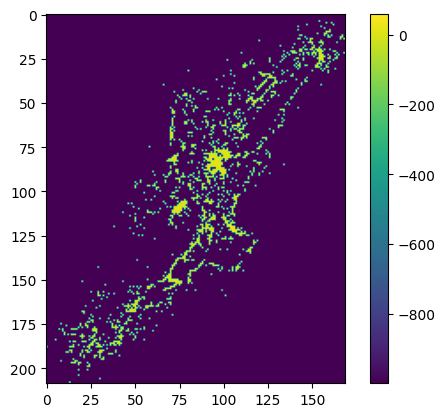

In [28]:
t0 = time.time()
minX = 999999999
minY = 999999999

maxX = -999999999
maxY = -999999999

PU = ListeLigne.returnValues(["Src", "Dest"], "Unique")
PU += ListeLigne.returnValues(["Dest", "Src"], "Unique")
PUnique = [list(x) for x in set(tuple(x) for x in PU)]
for X,Y in PUnique :
    if X < minX :
        minX = X
    if X > maxX :
        maxX = X
    if Y < minY :
        minY = Y
    if Y > maxY :
        maxY = Y
        
Taille = 100
NbX = int(((maxX + Taille) - minX)/Taille)
NbY = int(((maxY + Taille) - minY )/Taille)
print(NbX, NbY)
A = np.full((NbY, NbX), -999, dtype=int)
for indexY, subA in enumerate(A) :
    for indexX, sub in enumerate(subA) :
        XMin = minX  + (indexX *Taille)
        XMax = XMin + Taille
        YMax = maxY - (indexY*Taille)
        YMin = YMax - Taille
        Compteur = len([x for x in PUnique if x[0] < XMax and x[0] >= XMin and  x[1] < YMax and x[1] >= YMin])
        if Compteur > 0 :
            A[indexY, indexX] = Compteur
    print(indexY)
print(time.time() - t0)  

import matplotlib.pyplot as plt
plt.imshow(A)
plt.colorbar()
plt.set_cmap('viridis')
plt.show()

On check quels points des routes sont les plus proches des points d'eau

In [7]:
LigneInOutLignes = ListeLigne.returnValues(["Src", "idSrc"], "")
LigneInOutLignes += ListeLigne.returnValues(["Dest", "idDest"], "")
print(len(LigneInOutLignes))

shapefile = r"C:\Users\33647\Downloads\Jura\export_pointdeau_jura_2_Project.shp"
driver = ogr.GetDriverByName("ESRI Shapefile")
dataSource = driver.Open(shapefile, 1)
layer = dataSource.GetLayer()

LPointDeau = list()

CompteurSegment = 0
CompteurFeature = 0
Point = []

t0 = time.time()

for indexPoint, feature in enumerate(layer) :
    CompteurFeature += 1
    MaxSpeed = feature.GetField("amenity")
    geom = feature.GetGeometryRef()
    Point = geom.GetPoint()
    X = round(Point[0],0)
    Y = round(Point[1],0)
    print(X,Y)
    Point = [X, Y]
    Array = [[x[0], x[1], CalculDistance(x[0], Point, False), indexPoint] for x in LigneInOutLignes]
    LPointDeau.append(min(Array,key=itemgetter(2)))
    
del layer, feature, Array, LigneInOutLignes

12740
934745.0 6603021.0
940489.0 6608920.0
940449.0 6608666.0
932550.0 6600386.0


Path Finding !

In [8]:
t0 = time.time()

class LIPoint() :
    
    def __init__(self):
        self.Points = []

    def addPoint(self, Point):
        self.Points.append(Point)
        
    def setPointFinal(self):
        for IP in self.Points :
            IP.getPointFinal()

class InfoPoint():
    def __init__(self, ID) :
        self.ID = ID
        self.DistPoint1 = 0
        self.DistPoint2 = 0
        self.DistPoint3 = 0
        self.DistPoint4 = 0
        self.PointFinal = 999
        self.DistPointFinal =999
    
    def setPointDeau(self, ID, Dist) :
        if ID == 0 :
            self.DistPoint1 = Dist
        elif ID == 1 :
            self.DistPoint2 = Dist
        elif ID == 2 :
            self.DistPoint3 = Dist
        elif ID == 3 :
            self.DistPoint4 = Dist
    
    def getPointFinal(self) :
        Liste = list(self.__dict__.values())[1:-2]
        MinDist = min(Liste)
        idPoint = Liste.index(MinDist)
        self.DistPointFinal = MinDist
        self.PointFinal = idPoint 

ListeLigne.uniqueIDSection()
ListeLigne.calculWeightGlobal()

import networkx as nx

G = nx.Graph()

for Section in ListeLigne.Sections :
    G.add_edge(Section.idDest, Section.idSrc, weight=Section.Weight)


ListePointLigneInOut =  ListeLigne.returnValues(["idSrc", "idDest"], "Unique")

LIP = LIPoint()
Compteur = 0

for nbPoint, Point in enumerate(ListePointLigneInOut): 
    IP = InfoPoint(Point)
    for Index, PointEau in enumerate(LPointDeau) :
        idPointEau = PointEau[1]
        try :
            DistToPointEau = nx.dijkstra_path_length(G, Point, idPointEau, weight='weight')
            PointToEau = (PointEau[2]/(5.0/3.6))/60.0
            DistTot = PointToEau + DistToPointEau
            IP.setPointDeau(Index, DistTot)
        except :
            Compteur += 1
            IP.setPointDeau(Index, 999)
    LIP.addPoint(IP)
            
print(time.time() - t0)
del ListePointLigneInOut

250.3824541568756


On récupère tous les points qui sont maintenant reliés à un point d'eau

In [9]:
t0 = time.time()

LIP.setPointFinal()
AllPoint = dict()
           
for Index, PointEau in enumerate(LPointDeau) :
    ListPoint = list()
    for Point in LIP.Points :
        if Point.PointFinal == Index :
            ListPoint.append(Point.ID)
    print(len(ListPoint))
    Data = ListeLigne.CheckAndSetPointFinal(ListPoint, Index)
    print("Data", len(Data))
    if Data :
        AllPoint.update(Data)
    
print(time.time() - t0)


4969
Data 12110
1152
Data 2794
380
Data 847
6239
Data 13407
2.191685438156128


0 0.0034270286560058594
1000 0.3360867500305176
2000 0.6348915100097656
3000 0.9328835010528564
4000 1.230510950088501
5000 2.71073055267334
6000 3.0449154376983643
7000 3.3355300426483154
8000 3.6388890743255615
9000 3.9365243911743164
10000 4.249711990356445
11000 4.543493986129761
12000 4.8551106452941895
13000 5.150690793991089
14000 5.440074682235718
15000 5.725565433502197
16000 6.025920391082764
17000 6.320358753204346
18000 6.608504772186279
19000 6.903707504272461
20000 7.195176839828491
21000 7.489065647125244
22000 7.780282258987427
23000 8.085143566131592
24000 8.376965999603271
25000 8.70803165435791
26000 9.004334211349487
27000 9.283091306686401
28000 9.557571649551392
29000 9.845348119735718


<Axes: >

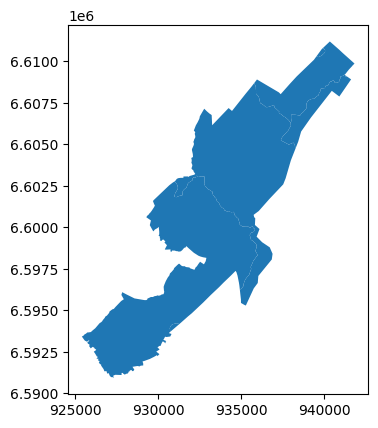

In [31]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.ops import voronoi_diagram
import json

file = ogr.Open(r"C:\Users\33647\Downloads\Jura\Extent_EPCI_LesRousses.shp")
shape = file.GetLayer(0)
feature = shape.GetFeature(0)
first = feature.ExportToJson()
data = json.loads(first)

# Créer le polygone limite
poly_limit = Polygon([(x[0], x[1]) for x in data['geometry']['coordinates'][0]])

# Créer les points dans un GeoDataFrame
d = {'eau':[value for value in AllPoint.values()], 'geometry': [Point(coord.split('-')[0], coord.split('-')[1]) for coord in AllPoint.keys()]}
points = gpd.GeoDataFrame(d, crs="EPSG:2154")
voronoi = voronoi_diagram(points.unary_union, envelope=poly_limit)

voronoi_gpd = gpd.GeoDataFrame(geometry=[poly for poly in voronoi.geoms], crs="EPSG:2154")
join = gpd.sjoin(left_df=voronoi_gpd, right_df=points,  how="left", predicate="intersects")

eau_list = list()
voronoi_list = list()

t0 = time.time()
for index in list(range(0, len(join) - 1)) :
    geometry = join.loc[index,'geometry']
    if geometry.intersects(poly_limit) :
        newgeometry = geometry.intersection(poly_limit)
        voronoi_list.append(newgeometry)
        eau_list.append(join.loc[index,'eau'])
    if index%1000 == 0:
        print(index, time.time() - t0)

d_clear = {'eau':eau_list, 'geometry': voronoi_list}
voronoi_clipped = gpd.GeoDataFrame(d_clear, crs="EPSG:2154")
voronoi_dissolved = voronoi_clipped.dissolve('eau')
voronoi_dissolved.plot()

Pour la distance et non le temps 

447565.8907673359
4692
Data 11606
1271
Data 67
329
Data 0
6448
Data 411
1.004621982574463
0 0.0039997100830078125
1000 0.3756837844848633
2000 0.7238979339599609
3000 1.047389030456543
4000 1.3816163539886475
5000 1.7209088802337646
6000 2.06235671043396
7000 2.4082958698272705
8000 2.81355357170105
9000 3.2271981239318848
10000 3.6627914905548096
11000 4.131076335906982
12000 4.487135410308838


<Axes: >

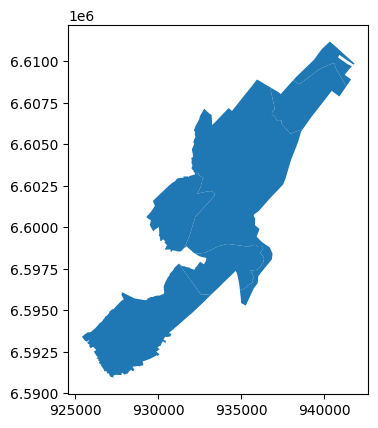

In [33]:
import networkx as nx

G = nx.Graph()

for Section in ListeLigne.Sections :
    G.add_edge(Section.idDest, Section.idSrc, weight=Section.Dist)


ListePointLigneInOut =  ListeLigne.returnValues(["idSrc", "idDest"], "Unique")


LIP = LIPoint()
Compteur = 0

for nbPoint, Point in enumerate(ListePointLigneInOut): 
    IP = InfoPoint(Point)
    for Index, PointEau in enumerate(LPointDeau) :
        idPointEau = PointEau[1]
        try :
            DistToPointEau = nx.dijkstra_path_length(G, Point, idPointEau, weight='weight')
            PointToEau = PointEau[2]
            DistTot = PointToEau + DistToPointEau
            IP.setPointDeau(Index, DistTot)
        except :
            Compteur += 1
            IP.setPointDeau(Index, 999)
    LIP.addPoint(IP)
            
print(time.time() - t0)
del ListePointLigneInOut

t0 = time.time()

LIP.setPointFinal()
AllPoint = dict()
           
for Index, PointEau in enumerate(LPointDeau) :
    ListPoint = list()
    for Point in LIP.Points :
        if Point.PointFinal == Index :
            ListPoint.append(Point.ID)
    print(len(ListPoint))
    Data = ListeLigne.CheckAndSetPointFinal(ListPoint, Index)
    print("Data", len(Data))
    if Data :
        AllPoint.update(Data)
    
print(time.time() - t0)

import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.ops import voronoi_diagram
import json

file = ogr.Open(r"C:\Users\33647\Downloads\Jura\Extent_EPCI_LesRousses.shp")
shape = file.GetLayer(0)
feature = shape.GetFeature(0)
first = feature.ExportToJson()
data = json.loads(first)

# Créer le polygone limite
poly_limit = Polygon([(x[0], x[1]) for x in data['geometry']['coordinates'][0]])

# Créer les points dans un GeoDataFrame
d = {'eau':[value for value in AllPoint.values()], 'geometry': [Point(coord.split('-')[0], coord.split('-')[1]) for coord in AllPoint.keys()]}
points = gpd.GeoDataFrame(d, crs="EPSG:2154")
voronoi = voronoi_diagram(points.unary_union, envelope=poly_limit)

voronoi_gpd = gpd.GeoDataFrame(geometry=[poly for poly in voronoi.geoms], crs="EPSG:2154")
join = gpd.sjoin(left_df=voronoi_gpd, right_df=points,  how="left", predicate="intersects")

eau_list = list()
voronoi_list = list()

t0 = time.time()
for index in list(range(0, len(join) - 1)) :
    geometry = join.loc[index,'geometry']
    if geometry.intersects(poly_limit) :
        newgeometry = geometry.intersection(poly_limit)
        voronoi_list.append(newgeometry)
        eau_list.append(join.loc[index,'eau'])
    if index%1000 == 0:
        print(index, time.time() - t0)

d_clear = {'eau':eau_list, 'geometry': voronoi_list}
voronoi_clipped = gpd.GeoDataFrame(d_clear, crs="EPSG:2154")
voronoi_dissolved = voronoi_clipped.dissolve('eau')
voronoi_dissolved.plot()


In [ ]:
# In[ ]:


ListeLigne.uniqueIDSection()
ListeLigne.calculWeightGlobal()

Export = ListeLigne.returnValues(["idSrc", "idDest", "Weight"], "")
Compteur = 0
for elem in ListeLigne.Sections :
    if elem.idDest == elem.idSrc :
        elem.SameOrigin = "OUI"
    else :
        elem.SameOrigin = "NON"

try :
          
    driver = ogr.GetDriverByName("ESRI Shapefile")
    ds = driver.CreateDataSource(r"C:\Users\33647\Downloads\Jura\FirstExport_newPart2.shp")
    
    # create the spatial reference system, WGS84
    srs =  osr.SpatialReference()
    srs.ImportFromEPSG(2154)
    
    # create one layer 
    layer = ds.CreateLayer("line", srs, ogr.wkbLineString)
    
    # Add an ID field
    idField = ogr.FieldDefn("id", ogr.OFTInteger)
    layer.CreateField(idField)
    distField = ogr.FieldDefn("distance", ogr.OFTReal)
    layer.CreateField(distField)
    MSField = ogr.FieldDefn("max_speed", ogr.OFTReal)
    layer.CreateField(MSField)
    HWField = ogr.FieldDefn("highway", ogr.OFTString)
    layer.CreateField(HWField)
    SOField = ogr.FieldDefn("same_o", ogr.OFTString)
    layer.CreateField(SOField)
    SOField = ogr.FieldDefn("ajout", ogr.OFTString)
    layer.CreateField(SOField)
    featureDefn = layer.GetLayerDefn()
    
    for ID, Section in enumerate(ListeLigne.Sections) :
        if len(Section.Path) > 1 :
            feature = ogr.Feature(featureDefn)
            linegeo = ogr.Geometry(ogr.wkbLineString)
            for Point in Section.Path :
                linegeo.AddPoint(Point[0],Point[1])
            feature.SetGeometry(linegeo)
            feature.SetField("id", ID)
            feature.SetField("distance", Section.Dist)
            feature.SetField("max_speed", Section.MaxSpeed)
            feature.SetField("highway", Section.HighWay)
            feature.SetField("same_o", Section.SameOrigin)
            feature.SetField("ajout", Section.Ajout)
    
            layer.CreateFeature(feature)

            feature = None
    
    # Save and close DataSource
    ds = None
    
except Exception as e:
    print(e)
